# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio 
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


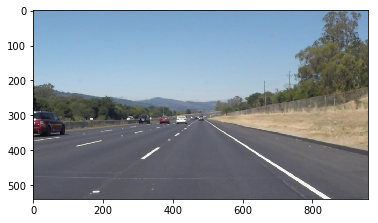

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

In [3]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []


In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    Combining this function with the weighted_img() function
    below to make the lines semi-transparent
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < img.shape[1]/2 and x2 < img.shape[1]/2:
                left_line_x.append(x1)
                left_line_y.append(y1)
                left_line_x.append(x2)
                left_line_y.append(y2)
            if x1 > img.shape[1]/2 and x2 > img.shape[1]/2:
                right_line_x.append(x1)
                right_line_y.append(y1)
                right_line_x.append(x2)
                right_line_y.append(y2)
    
    left_fit_line = np.polyfit(left_line_x, left_line_y, 1)
    left_line_y_min = int(min(np.polyval(left_fit_line,left_line_x)))
    left_line_x_min = int((left_line_y_min-left_fit_line[1])/left_fit_line[0])
    left_line_y_max = img.shape[1]
    left_line_x_max = int((left_line_y_max-left_fit_line[1])/left_fit_line[0])
    
    right_fit_line = np.polyfit(right_line_x, right_line_y, 1)
    right_line_y_min = int(min(np.polyval(right_fit_line,right_line_x)))
    right_line_x_min = int((right_line_y_min-right_fit_line[1])/right_fit_line[0])
    right_line_y_max = img.shape[1]
    right_line_x_max = int((right_line_y_max-right_fit_line[1])/right_fit_line[0])
    
    cv2.line(img, (left_line_x_max, left_line_y_max), (left_line_x_min, left_line_y_min), color, thickness)
    cv2.line(img, (right_line_x_min, right_line_y_min), (right_line_x_max, right_line_y_max), color, thickness) 

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + lambd
    NOTE: initial_img and img must be the same shape.
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build pipeline to work on the images in the directory "test_images"

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run on all test_images. Make copies into the `test_images_output` directory.

In [6]:
def process_image(image):
    # Create color image (3 channel) for processing video below
    
    # Convert to grayscale
    gray = grayscale(image)
    # Detect edges
    gray_edges = canny(gray, 50, 150)
    # Apply gaussian blur
    gaus_gray_edges = gaussian_blur(gray_edges, 5)
    # Apply ROI mask and threshold
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(425, 325), (575, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    region_gaus_gray_edges = region_of_interest(gaus_gray_edges, [vertices])
    # Hough lines
    lines_region_gaus_gray_edges = hough_lines(region_gaus_gray_edges, 2, 1, 15, 40, 20)
    # Weighted lines
    weighted_lines_region_gaus_gray_edges = weighted_img(lines_region_gaus_gray_edges, image, α=0.8, β=1., λ=0.)
    result = weighted_lines_region_gaus_gray_edges
    # Return the final output (image where lines are drawn on lanes)
    return result

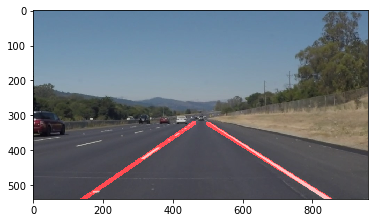

In [7]:
plt.imshow(process_image(image))

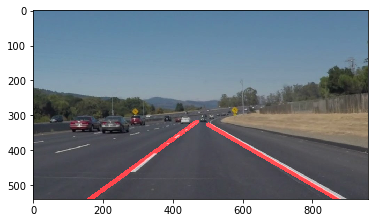

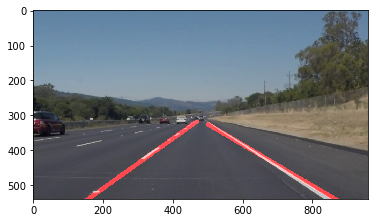

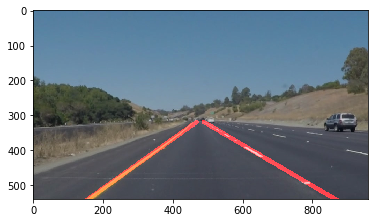

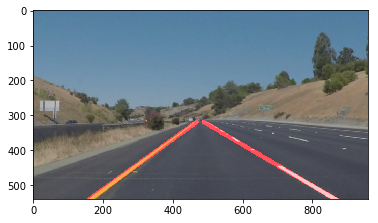

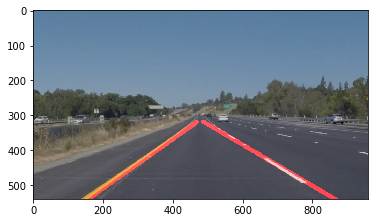

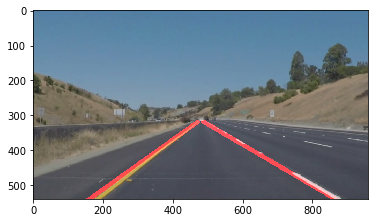

In [8]:
# Process images in directory through pipeline, export them and display them
for i in os.listdir("test_images/"):
    picture = mpimg.imread("test_images/" + i)
    processed_picture = process_image(picture)
    plt.figure()
    plt.imshow(processed_picture)
    plt.imsave("test_images_output/output_" + i, processed_picture)

## Test on Videos

Test solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 12.6 s, sys: 1.61 s, total: 14.2 s
Wall time: 4.87 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Defining a line to run the full length of the visible lane based on the line segments identified with the Hough Transform.

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:27<00:00, 17.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 32s, sys: 8.5 s, total: 1min 41s
Wall time: 28.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))